In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
np.set_printoptions(precision=4)

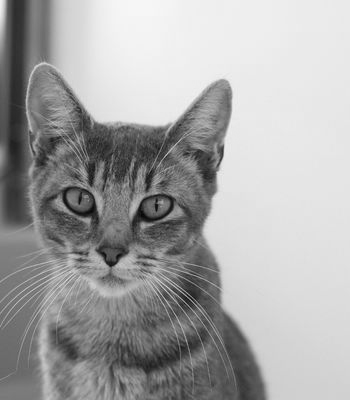

In [3]:
# g === area (big image)
# f === fragment
g = Image.open('img/catcare.jpg').convert('L').crop((0, 0, 350, 400))
g

In [4]:
g.size
g_mat = np.asarray(g.getdata(), dtype=int).reshape(g.size[1], g.size[0])

(200, 200)


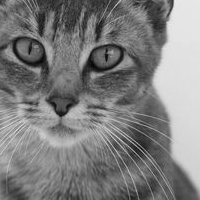

In [5]:
# Crop fragment from area image
xf = 50
yf = 150
wf = 200
hf = 200

crop_box = (xf, yf, xf + wf, yf + hf)
f = g.crop(crop_box)
print f.size
f

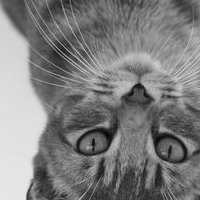

In [6]:
# Create matrix of fragment
f_mat = np.asarray(f.getdata(), dtype=int).reshape(f.size[1], f.size[0])
# Flip matrix
f_mat = np.fliplr(f_mat)
f_mat = np.flipud(f_mat)

Image.fromarray(f_mat.astype('uint8'), 'L')

In [7]:
num_shades = 256
# Create indicators of f
# of size == g.size
chi = np.zeros((num_shades, g.size[1], g.size[0]), dtype=bool)

In [8]:
# fill the indicators
for h in xrange(f.size[1]):
    for w in xrange(f.size[0]):
        color = f_mat[h, w]
        chi[color, h, w] = True

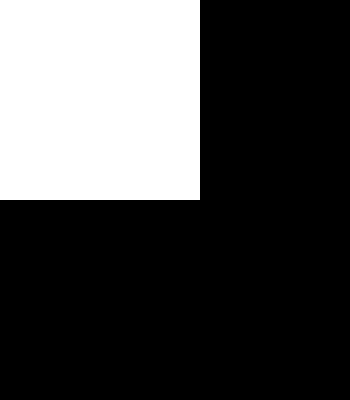

In [9]:
Image.fromarray(chi.sum(axis=0).astype('uint8')*(num_shades - 1), 'L')

In [10]:
# chi_elems[i] === number of pixels that have color "i"
chi_elems = np.array( f.histogram() )
print chi_elems

[  0   0   0   0   1   1   1   2   2   2   2   4   5   7   8   9  14  14
  13  19  13  23  21  16  32  26  28  20  34  35  28  25  28  24  38  34
  38  52  43  55  62  64  69  65  59  72  68  50  83  92  67 104 100 116
 113 137 130 149 131 163 165 148 167 153 183 161 186 205 232 211 216 212
 218 238 242 245 262 230 259 269 281 285 304 308 288 298 314 321 286 332
 304 307 318 314 345 337 339 327 363 341 389 357 379 388 356 372 375 381
 360 343 363 374 390 374 345 382 379 326 359 354 344 380 351 365 320 351
 315 374 353 338 305 308 310 306 278 287 315 274 252 279 292 283 253 283
 262 264 251 238 242 190 220 216 197 181 165 183 174 174 163 141 129 128
 157 116 124 109 131 123 121 104 110  96 110  89 107  79  90  86  89  92
  71  67  75  62  69  57  46  54  45  48  51  49  35  38  17  37  32  36
  26  23  24  18  28  30  25  31  47  27  66 131 125 207 118 138 134 169
 137 153 207 238 373 224 399 405 339 460 172  83 305 481 230  71  15   7
   4   1   2   0   0   0   0   0   0   0   0   0   

In [11]:
fft_chi = np.fft.fft2(chi)

In [12]:
fft_g = np.fft.fft2(g_mat)

In [13]:
# Scalar product (g_frag, chi[i])
sp_g_frag_chi = np.zeros((num_shades, g.size[1] - hf, g.size[0] - wf))

for i in xrange(num_shades):
    if chi_elems[i] > 0:
        sp_g_frag_chi[i] = np.fft.ifft2(fft_g * fft_chi[i])[hf:, wf:]

/home/stan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: ComplexWarning: Casting complex values to real discards the imaginary part


In [14]:
# || Projection of g_frag on f ||^2
norm_pr_gfrag_sqr = np.zeros((g.size[1] - hf, g.size[0] - wf))
for i in xrange(num_shades):
    if chi_elems[i] > 0:
        norm_pr_gfrag_sqr += sp_g_frag_chi[i] ** 2 / float(chi_elems[i])

In [15]:
# chi_X -- const field of vision
# 1 1 1 0 0 ... 0
# 1 1 1 0 0 ... 0
# 1 1 1 0 0 ... 0
# 0 0 0 0 0 ... 0
# . . .
# 0 0 0 0 0 ... 0
chi_X = np.zeros((g.size[1], g.size[0]), dtype=bool)
chi_X[:hf, :wf] = np.ones((hf, wf))

print 'g_mat.min():', g_mat.min()
print 'g_mat.min():', (g_mat**2).min()

# || g ||^2
fft_gsqr = np.fft.fft2(g_mat ** 2)

fft_chi_X = np.fft.fft2(chi_X)
norm_gfrag_sqr = np.fft.ifft2(fft_gsqr * fft_chi_X)[hf:, wf:].astype('float')

g_mat.min(): 4
g_mat.min(): 16


/home/stan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:18: ComplexWarning: Casting complex values to real discards the imaginary part


In [16]:
norm_E_gfrag_sqr = np.fft.ifft2(fft_g * fft_chi_X)[hf:, wf:].astype('float') \
                        ** 2 / (hf * wf)

/home/stan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


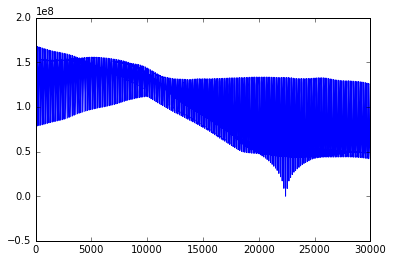

In [17]:
numerator = norm_gfrag_sqr - norm_pr_gfrag_sqr
plt.plot(numerator.ravel())

In [18]:
denominator = norm_pr_gfrag_sqr - norm_E_gfrag_sqr

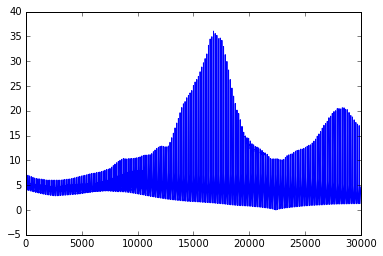

In [19]:
tau = numerator / denominator
plt.plot(tau.ravel())

In [20]:
true_idx = (yf-1) * tau.shape[1] + xf-1
index = tau.argmin() 
x_min = index % tau.shape[1] + 1
y_min = index // tau.shape[1] + 1
print 'Tau min value:', tau.min()
print 'Tau argmin index', index
print 'Should be:', true_idx
print "x_min, y_min: %d %d" % (y_min, x_min)
print 'Should be:', (yf, xf)

Tau min value: -7.00373650641e-15
Tau argmin index 22399
Should be: 22399
x_min, y_min: 150 50
Should be: (150, 50)


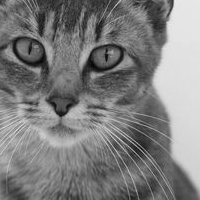

In [21]:
Image.fromarray(g_mat[y_min : y_min + hf , x_min : x_min + wf].astype('uint8'), 'L')

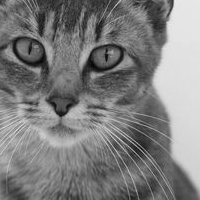

In [22]:
f